<a href="https://colab.research.google.com/github/Sobiam1/Smart-Music-Generator/blob/master/smart_music_geny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Smart music generator based on input songs**

In [9]:
# Package to include in your colab notebook to run this file
!pip install pydub      # splitting audio files and stuff

## Load all necessary packages

import numpy as np
import pandas as pd
import pydub
from pydub import AudioSegment
from pydub.playback import play

from keras.layers import Dense, LSTM, LeakyReLU
from keras.models import Sequential, load_model
from scipy.io.wavfile import read, write 
from scipy.io import wavfile

In [0]:
# # This one is used to upload your file to Google's cloud servers in case you run this on Google Colab
from google.colab import files
files.upload()

In [0]:
# # Converting from mp3 to wav if you have mp3 files instead


# pydub.AudioSegment.converter = r"C:\Program Files\ffmpeg\bin\ffmpeg.exe"
# pydub.AudioSegment.ffmpeg = r"C:\Program Files\ffmpeg\bin\ffmpeg.exe"


# aud = pydub.AudioSegment.from_mp3("Kalimba.mp3")
# aud.export("Kalimba.wav", format="wav")
# Kalimba = AudioSegment.from_file("Numb.wav", format="wav")
# play(Kalimba)

# aud = pydub.AudioSegment.from_mp3('Numb_piano.mp3')
# aud.export("Numb.wav", format="wav")
# numb = AudioSegment.from_file("Numb.wav", format="wav")
# play(numb)

In [0]:
# Load wav files

rate, music1 = read('Numb.wav')
rate, music2 = read('Kalimba.wav')

In [13]:
# Convert samples of the songs to a dataframe
# Music files are sampled and converted into discrete signals whre each music second 
# corresponds to thousands of samples depending in  the sampling rate. Scipy generates 44100 samples per second.
# We will try to train the model on just few seconds(the whole data is huge and needs time and computing power...)

music1 = pd.DataFrame(music1[0:400000, :])
music2 = pd.DataFrame(music2[0:400000, :])

music1.head(10)
music2.tail(10)


,0,1
399990,-353,-860
399991,-667,-1209
399992,-730,-1011
399993,-296,-476
399994,-427,-631
399995,-1504,-1428
399996,-2300,-1973
399997,-1895,-1838
399998,-1110,-1370
399999,-877,-1125


In [0]:
# The output of our music dataframe is 2 columns (channels)
# We will train two models on these 2 channels and then predict for both channels
# At the end wi will concatenate the results toform a new piece of music

# Data Preprocessing:
# This helper function will prepare data before feeding it to the LSTM neural network
# Each model will access one column of the music dataframe. To tackle this as a regresson problem, we will arrange data
# so that each value can be predicted based on three previous consecutive values (look_back=3)

# Create training data by shifting music data
# The helper takes three arguments: dataframe, number of previous values to predict on and train tag(to generate training/test data)
# data_x1, data_x2 are the features for channels 1 & 2 which dimensions depend on the 'look_back=3' => array of ( , 3) dimension.
# Output: data_x1, data_x2 are features (independant variables). data_y1, data_y2 are labels (dependant variables)
# Train=True will generate training data as well as labels i.e. test data
def create_train_data(df, look_back, train=True):
    data_x1, data_x2, data_y1, data_y2 = [], [], [], []
    for i in range(len(df)-look_back-1):
        data_x1.append(df.iloc[i : i+look_back, 0].values)
        data_x2.append(df.iloc[i : i+look_back, 1].values)
        if train:
            data_y1.append(df.iloc[i+look_back, 0])
            data_y2.append(df.iloc[i+look_back, 1])
    if train:
        return np.array(data_x1), np.array(data_x2), np.array(data_y1), np.array(data_y2)
    else:
        return np.array(data_x1), np.array(data_x2)
                   


In [0]:

# Generate trainnig data by concatenating two music1 and music2 dataframes which have two different songs 

mix = pd.concat([music1.iloc[0:160000, :], music2.iloc[0:160000, :]], axis=0)
x1, x2, y1, y2 = create_train_data(mix, look_back=3, train=True)

# Generate test data by passing the train parameter to False

mix2 = pd.concat([music1.iloc[160001:400000, :], music2.iloc[160001:400000, :]], axis=0)
test1, test2 = create_train_data(mix, look_back=3, train=False)
 
# Reshape our 2D data into 3D vector (expected by LSTM)

x1 = x1.reshape((-1, 1, 3))
x2 = x2.reshape((-1, 1, 3))
test1 = test1.reshape((-1, 1, 3))
test2 = test2.reshape((-1, 1, 3))

In [16]:
# Training the model

# LSTM Model for the channel 1 of the music data
rn1 = Sequential()
rn1.add(LSTM(units=100, activation='relu', input_shape=(None, 3), return_sequences=False))
rn1.add(Dense(units=50, activation='relu'))
rn1.add(Dense(units=25, activation='relu'))
rn1.add(Dense(units=12, activation='relu'))
rn1.add(Dense(units=1, activation='relu'))

# Compile the model
# loss function is used to evaluate the network that is minimized by the 'optimization algorithm'
rn1.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model:
# The network is trained using the backpropagation algorithm and optimized according to the optimization algorithm and loss function 
# specified when compiling the model
# The amount of information displayed can be reduced to just the loss each epoch by setting the verbose argument to 2. 
# You can turn off all output by setting verbose to 0
rn1.fit(x1, y1, batch_size=100, epochs=20, verbose=2)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
 - 29s - loss: 6912800.9765
Epoch 2/20
 - 25s - loss: 6851603.2298
Epoch 3/20
 - 24s - loss: 6850749.5843
Epoch 4/20
 - 24s - loss: 6852658.8912
Epoch 5/20
 - 24s - loss: 6849899.4421
Epoch 6/20
 - 24s - loss: 6846723.2185
Epoch 7/20
 - 25s - loss: 6847768.4779
Epoch 8/20
 - 24s - loss: 6845727.4149
Epoch 9/20
 - 24s - loss: 6845889.4974
Epoch 10/20
 - 25s - loss: 6846834.5277
Epoch 11/20
 - 24s - loss: 6846937.6400
Epoch 12/20
 - 24s - loss: 6845821.1969
Epoch 13/20
 - 24s - loss: 6844924.4651
Epoch 14/20
 - 24s - loss: 6844864.7047
Epoch 15/20
 - 25s - loss: 6846425.3715
Epoch 16/20
 - 24s - loss: 6843965.0380
Epoch 17/20
 - 25s - loss: 6844220.4728
Epoch 18/20
 - 24s - loss: 6843514.7974
Epoch 19/20
 - 24s - loss: 6842734.5197
Epoch 20/20
 - 24s - loss: 6842627.3456


In [19]:
# LSTM Model for the channel 2 of the music data
rn2 = Sequential()
rn2.add(LSTM(units=100, activation='relu', input_shape=(None, 3), return_sequences=False))
rn2.add(Dense(units=50, activation='relu'))
rn2.add(Dense(units=25, activation='relu'))
rn2.add(Dense(units=12, activation='relu'))
rn2.add(Dense(units=1, activation='relu'))

# Compile the model
# loss function is used to evaluate the network that is minimized by the 'optimization algorithm'
rn2.compile(optimizer='adam', loss='mean_squared_error')

#Fit the model:
rn2.fit(x2, y2, batch_size=100, epochs=20, verbose=2)

Epoch 1/20
 - 25s - loss: 6466135.4167
Epoch 2/20
 - 24s - loss: 6387597.2827
Epoch 3/20
 - 24s - loss: 6383537.6073
Epoch 4/20
 - 24s - loss: 6384729.2867
Epoch 5/20
 - 25s - loss: 6384231.4448
Epoch 6/20
 - 24s - loss: 6382619.2041
Epoch 7/20
 - 25s - loss: 6381034.0925
Epoch 8/20
 - 25s - loss: 6381342.2450
Epoch 9/20
 - 24s - loss: 6382655.0634
Epoch 10/20
 - 24s - loss: 6381332.5240
Epoch 11/20
 - 24s - loss: 6378800.9163
Epoch 12/20
 - 24s - loss: 6379946.8249
Epoch 13/20
 - 25s - loss: 6377641.9624
Epoch 14/20
 - 25s - loss: 6380650.8197
Epoch 15/20
 - 25s - loss: 6381861.1760
Epoch 16/20
 - 24s - loss: 6377444.5230
Epoch 17/20
 - 25s - loss: 6378242.9656
Epoch 18/20
 - 25s - loss: 6377394.7227
Epoch 19/20
 - 25s - loss: 6376108.9159
Epoch 20/20
 - 25s - loss: 6377099.9401


In [0]:
# Prediction on the training data

pred_rn1 = rn1.predict(test1)
pred_rn2 = rn1.predict(test2)

# Save results in wav formats to compare them

# Save the LSTM predictions in wav format
write('pred_song.wav', rate, pd.concat([pd.DataFrame(pred_rn1.astype('int16')),
                                       pd.DataFrame(pred_rn2.astype('int16'))], axis=1).values)
                                       
# Save the original music in wav format
write('original.wav', rate, pd.concat([music1.iloc[160001 : 400000, :], 
                                       music2.iloc[160001 : 400000, :]], axis=0).values)

In [0]:
# This one is used to download your file from Google's cloud servers in case you run this on Google Colab
from google.colab import files
files.download('pred_song.wav')
files.download('original.wav')

In [22]:
## RE-Training the model with new Activation function

## LSTM Model for the channel 1 of the music data with 'activation=linear' using 'LeakyReLU'
rn1 = Sequential()
rn1.add(LSTM(units=100, activation='linear', input_shape=(None, 3), return_sequences=False))
rn1.add(LeakyReLU())
rn1.add(Dense(units=50, activation='linear'))
rn1.add(LeakyReLU())
rn1.add(Dense(units=25, activation='linear'))
rn1.add(LeakyReLU())
rn1.add(Dense(units=12, activation='linear'))
rn1.add(LeakyReLU())
rn1.add(Dense(units=1, activation='linear'))
rn1.add(LeakyReLU())

# Compile the model
# loss function is used to evaluate the network that is minimized by the 'optimization algorithm'
rn1.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
rn1.fit(x1, y1, batch_size=100, epochs=20, verbose=2)


## RE- LSTM Model for the channel 2 of the music data with 'activation=linear' using 'LeakyReLU'
rn2 = Sequential()
rn2.add(LSTM(units=100, activation='linear', input_shape=(None, 3), return_sequences=False))
rn2.add(LeakyReLU())
rn2.add(Dense(units=50, activation='linear'))
rn2.add(LeakyReLU())
rn2.add(Dense(units=25, activation='linear'))
rn2.add(LeakyReLU())
rn2.add(Dense(units=12, activation='linear'))
rn2.add(LeakyReLU())
rn2.add(Dense(units=1, activation='linear'))
rn2.add(LeakyReLU())

# Compile the model
# loss function is used to evaluate the network that is minimized by the 'optimization algorithm'
rn2.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
rn2.fit(x2, y2, batch_size=100, epochs=20, verbose=2)



Epoch 1/20
 - 26s - loss: 474640.1608
Epoch 2/20
 - 25s - loss: 328532.6887
Epoch 3/20
 - 24s - loss: 326096.9000
Epoch 4/20
 - 25s - loss: 323323.2315
Epoch 5/20
 - 24s - loss: 322886.1751
Epoch 6/20
 - 25s - loss: 320577.4031
Epoch 7/20
 - 25s - loss: 320011.5544
Epoch 8/20
 - 24s - loss: 321898.3345
Epoch 9/20
 - 25s - loss: 319520.3609
Epoch 10/20
 - 25s - loss: 316852.3649
Epoch 11/20
 - 25s - loss: 316270.5992
Epoch 12/20
 - 25s - loss: 314778.6675
Epoch 13/20
 - 25s - loss: 314376.6873
Epoch 14/20
 - 25s - loss: 314475.5482
Epoch 15/20
 - 25s - loss: 314303.8420
Epoch 16/20
 - 24s - loss: 312417.8612
Epoch 17/20
 - 24s - loss: 314708.6318
Epoch 18/20
 - 25s - loss: 312057.9867
Epoch 19/20
 - 25s - loss: 312340.9274
Epoch 20/20
 - 25s - loss: 312838.7066
Epoch 1/20
 - 26s - loss: 470485.6124
Epoch 2/20
 - 25s - loss: 322969.7885
Epoch 3/20
 - 24s - loss: 320122.0645
Epoch 4/20
 - 25s - loss: 318626.4103
Epoch 5/20
 - 25s - loss: 316906.6889
Epoch 6/20
 - 25s - loss: 315130.4995
E

In [0]:
## RE- Predict
pred_rn1 = rn1.predict(test1)
pred_rn2 = rn2.predict(test2)

# Save the LSTM predictions in wav format
write('pred_song_update.wav', rate, pd.concat([pd.DataFrame(pred_rn1.astype('int16')),
                                       pd.DataFrame(pred_rn2.astype('int16'))], axis=1).values)

In [0]:
# This one is used to download your file from Google's cloud servers in case you run this on Google Colab
from google.colab import files
files.download('pred_song_update.wav')

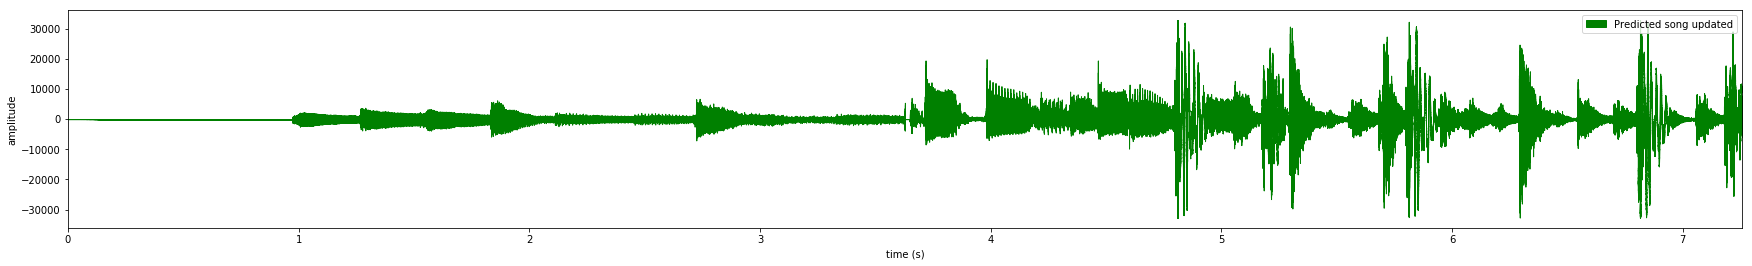

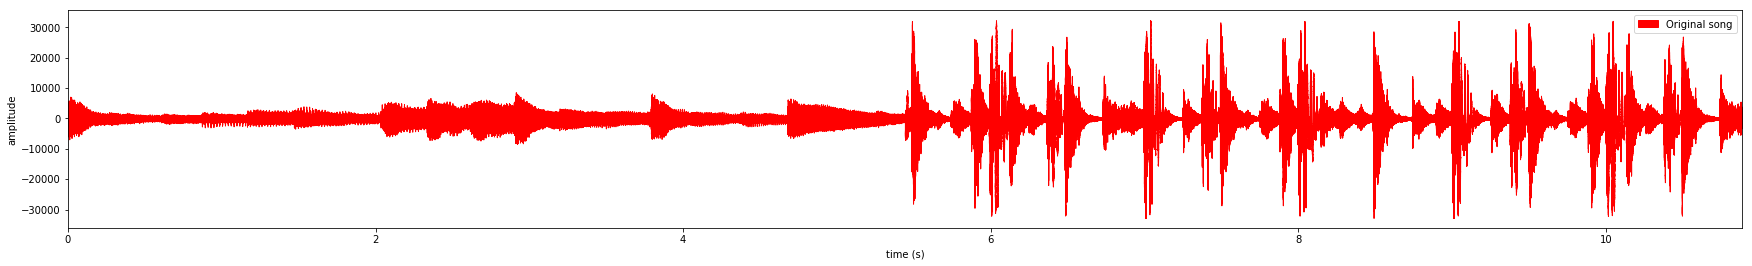

In [28]:
import matplotlib.pyplot as plt

# This function is used to plot the form of our two output songs forms to compare with original song
# These plots give an idea about their forms similarity as well as music signal data (amplitude and frequency)... 
# but be aware of the delay between them caused during the training...
def plot_wavs(file, color, label):
  
  # Load the data and calculate the time of each sample
  samplerate, data = wavfile.read(file)
  times = np.arange(len(data))/float(samplerate)

  # Make the plot
  # You can tweak the figsize (width, height) in inches
  plt.figure(figsize=(30, 4))
  plt.fill_between(times, data[:,0], data[:,1], color=color, label=label)
  plt.xlim(times[0], times[-1])
  plt.xlabel('time (s)')
  plt.ylabel('amplitude')
  plt.savefig('pred_song_update.png', dpi=100)
  plt.legend()
  plt.show()
  
plot_wavs('pred_song_update.wav', 'g', "Predicted song updated")
plot_wavs('original.wav', 'r', "Original song")